# Bandpass calibration

An important part of spectral line calibration is to correct for frequency dependent effects. We subtract a reference spectrum (off-source) from  our on-source observation in order to remove all common effects.

There are two ways to do this at HartRAO: position-switching and frequency switching. 

In position switching the reference spectrum is taken by pointing the telescope a few beam-widths away from the source.  The disadvantage of this method is that you spend half your time off your target, and in crowded regions it may not be possible to get away from other line-emission sources.

In frequency switching we shift the central observing frequency such that the line emission falls on different sides of the band for the signal and reference pair. This is more time-efficient position switching, but is not always possible if the frequency range of the line emission is more than half the bandwidth.

In the example below, I shall illustrate frequency switching for one of the masers regularly observed at HartRAO.

In [1]:
from astropy.io import fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.time import Time
%matplotlib inline

## Load and plot data

In [2]:
cwd = os.getcwd()
work_dir = cwd+'/data/G0096_67/2006d272'
os.chdir(work_dir)

In [3]:
ls

2006d272_16h21m02s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h22m17s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h23m32s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h25m22s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h26m37s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h27m37s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h36m17s_Spec_sharmila_G9.62+0.20.fits
2006d272_16h44m27s_Spec_sharmila_G9.62+0.20.fits
observation_list.txt


For Hart spectral line data, each integration is stored as a separate FITS file.  This particular sequence of observations consists of short pointing checks to the half-power cardinal points and the centre position, and a pair of frequency-switched full-length scans on the central position. Data is recorded in dual polarisation: LCP and RCP.

2006d175_21h14m12s_Spec_sharmila_G9.62+0.20.fits HPN Pointing

2006d175_21h15m22s_Spec_sharmila_G9.62+0.20.fits HPS Pointing

2006d175_21h16m32s_Spec_sharmila_G9.62+0.20.fits HPE Pointing

2006d175_21h18m17s_Spec_sharmila_G9.62+0.20.fits HPW Pointing

2006d175_21h19m27s_Spec_sharmila_G9.62+0.20.fits ON Pointing

2006d175_21h20m22s_Spec_sharmila_G9.62+0.20.fits ON Pointing

2006d175_21h28m52s_Spec_sharmila_G9.62+0.20.fits 

2006d175_21h36m57s_Spec_sharmila_G9.62+0.20.fits

The information on which files correspond to which can be found in the file called 'list'.  Note that the file extensions are in csv. This mechanism was set up for the use of the old spectral line analysis programme 'LINES'.  We are going to use the fits files instead.

In [4]:
if not os.path.exists('observation_list.txt'):
    os.system('ls *.fits > fits_list.txt')
    file_list = np.atleast_1d(np.loadtxt('fits_list.txt', dtype='string'))
    with open('observation_list.txt', 'w') as f:
        for filename in file_list:
            try:
                hdulist = pyfits.open(filename)
                position = hdulist[2].header['POSITION']
                pointing = str(hdulist[0].header['SPPOINT'])
                description = ' '.join([filename, position, pointing, '\n'])
                f.write(description)
            except IOError:
                print('Empty or corrupt file: %s'%filename)
    os.system('rm fits_list.txt')
    

In [5]:
file_list = np.loadtxt(fname='observation_list.txt', delimiter=' ', 
                       dtype={'names' : ('filename', 'position', 'pointing'),
                             'formats' : ('S100', 'S3', 'b')})
file_list

array([('2006d272_16h21m02s_Spec_sharmila_G9.62+0.20.fits', 'HPN', 1),
       ('2006d272_16h22m17s_Spec_sharmila_G9.62+0.20.fits', 'HPS', 1),
       ('2006d272_16h23m32s_Spec_sharmila_G9.62+0.20.fits', 'HPE', 1),
       ('2006d272_16h25m22s_Spec_sharmila_G9.62+0.20.fits', 'HPW', 1),
       ('2006d272_16h26m37s_Spec_sharmila_G9.62+0.20.fits', 'ON', 1),
       ('2006d272_16h27m37s_Spec_sharmila_G9.62+0.20.fits', 'ON', 1),
       ('2006d272_16h36m17s_Spec_sharmila_G9.62+0.20.fits', 'ON', 0),
       ('2006d272_16h44m27s_Spec_sharmila_G9.62+0.20.fits', 'ON', 0)], 
      dtype=[('filename', 'S100'), ('position', 'S3'), ('pointing', 'i1')])

In [6]:
def load_file(filename):
    """
    Open fits file, load spectra and extract information
    relevant to reductions.
    Returns a dictionary object.
    """
    hdulist = pyfits.open(filename)
    spectrum = {'Vlsr' : hdulist[2].data['Vlsr'],
                'LCP'  : hdulist[2].data['Polstate1'],
                'RCP'  : hdulist[2].data['Polstate4'],
                'units' : hdulist[2].header['TUNIT2'],
                'pointing' : hdulist[0].header['SPPOINT'],
                'position' : hdulist[2].header['POSITION'], 
                'HPBW' : hdulist[1].header['HPBW'],
                'date' : hdulist[0].header['DATE-OBS'],
                'object' : hdulist[0].header['OBJECT'],
                'longitude' : hdulist[0].header['LONGITUD'],
                'latitude' : hdulist[0].header['LATITUDE'],
                'equinox' : hdulist[0].header['EQUINOX'],
                'bw' : hdulist[0].header['SPBW'],
                'nchan' : hdulist[0].header['SPCHAN'],
                'integration' : hdulist[0].header['SPTIME'],
                'fs_offset' : hdulist[0].header['SPFS'],
                'spVlsr' : hdulist[0].header['SPVLSR'],
                'restfreq' : hdulist[0].header['RESTFREQ'],
                'centrefreq' : hdulist[2].header['CENTFREQ'], 
                'Tsys_lcp' : hdulist[3].header['TSYS1'],
                'DTsys_lcp' : hdulist[3].header['TSYSERR1'],
                'Tsys_rcp' : hdulist[3].header['TSYS2'],
                'DTsys_rcp': hdulist[3].header['TSYSERR2'] }
    return spectrum


In [7]:
#get indices of the on-source files
full_int_on = np.where(np.logical_and(file_list['position']=='ON', file_list['pointing']==0))[0]
on_fs1 = load_file(file_list['filename'][full_int_on[0]])
on_fs2 = load_file(file_list['filename'][full_int_on[1]])

Open up data files for a frequency-switched pair. We assume that consecutive observations are frequency-switched.

In [8]:
def plot_spec(spec):
    """ Produce spectral plots given spectral line data"""
    plt.figure(figsize=[15,3])
    plt.plot(spec['Vlsr'], spec['LCP'], label='LCP', linewidth=3)
    plt.plot(spec['Vlsr'], spec['RCP'], label='RCP', linewidth=3)
    plt.legend()
    plt.title(spec['object'] + ' ' + spec['date'])
    plt.xlabel('V_lsr (km/s)')
    plt.ylabel('Antenna temperature (K)')
    plt.axis('tight')

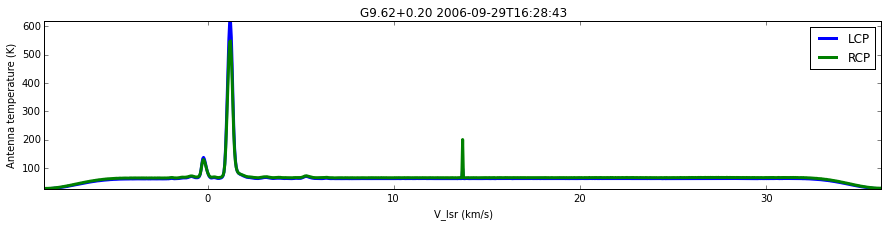

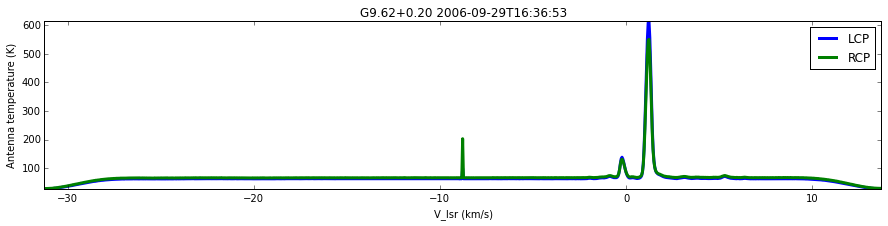

In [9]:
plot_spec(on_fs1)
plot_spec(on_fs2)

## Correct bandpass using frequency-switched reference spectra
Next we have a look at how we subtract the reference spectrum from each observation, and then combine them.

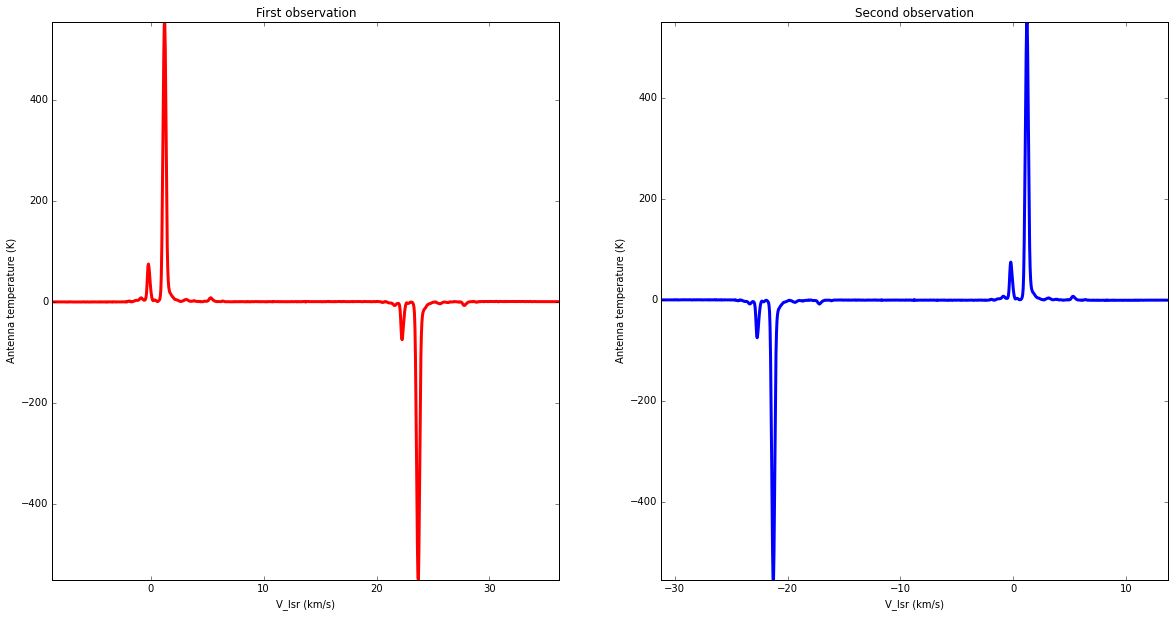

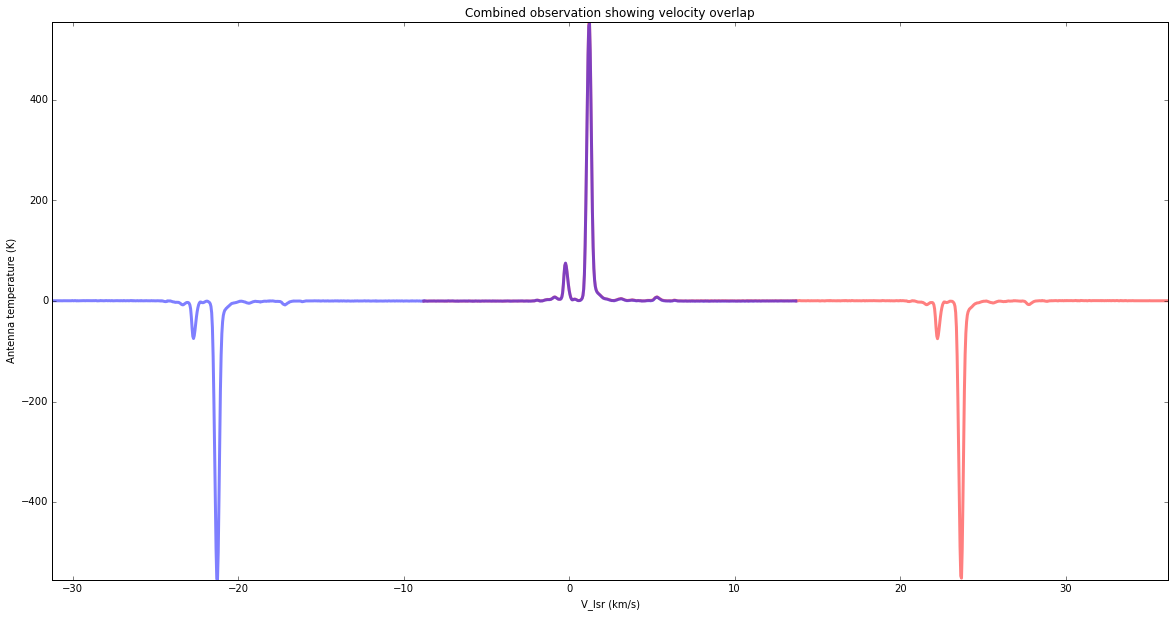

In [10]:
lcp1 = on_fs1['LCP'] - on_fs2['LCP']
lcp2 = on_fs2['LCP'] - on_fs1['LCP']
plt.figure(figsize=[20,10])
ax = plt.subplot(121)
plt.plot(on_fs1['Vlsr'], lcp1, color='r', linewidth=3)
lim=plt.axis('tight')
plt.xlabel('V_lsr (km/s)')
plt.ylabel('Antenna temperature (K)')
plt.title('First observation')
ax = plt.subplot(122)
plt.plot(on_fs2['Vlsr'], lcp2, color='b', linewidth=3)
lim=plt.axis('tight')
plt.xlabel('V_lsr (km/s)')
plt.ylabel('Antenna temperature (K)')
plt.title('Second observation')
plt.figure(figsize=[20,10])
plt.plot(on_fs1['Vlsr'], lcp1, color='r', linewidth=3, alpha=0.5)
plt.plot(on_fs2['Vlsr'], lcp2, color='b', linewidth=3, alpha=0.5)
lim=plt.axis('tight')
plt.xlabel('V_lsr (km/s)')
plt.ylabel('Antenna temperature (K)')
plt.title('Combined observation showing velocity overlap')



Note how the baseline is now quite flat, and the central spike from the spectrometer has also been removed.

In [11]:
#where do the velocities intersect?
spec1_common = np.in1d(on_fs1['Vlsr'], on_fs2['Vlsr'])
spec2_common = np.in1d(on_fs2['Vlsr'], on_fs1['Vlsr'])

In [12]:
spec1_common

array([ True,  True,  True, ..., False, False, False], dtype=bool)

In [13]:
spec2_common

array([False, False, False, ...,  True,  True,  True], dtype=bool)

As expected, the left half of the first spectrum and the right half of the second spectrum share common velocities.

Now, lets find the array indices for these common blocks.

In [14]:
spec1_common = np.nonzero(np.in1d(on_fs1['Vlsr'], on_fs2['Vlsr']))
spec2_common = np.nonzero(np.in1d(on_fs2['Vlsr'], on_fs1['Vlsr']))
print spec1_common
print spec2_common

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

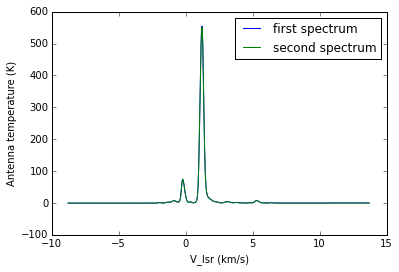

In [15]:
plt.plot(on_fs1['Vlsr'][spec1_common], lcp1[spec1_common], label = 'first spectrum')
plt.plot(on_fs2['Vlsr'][spec2_common], lcp2[spec2_common], label = 'second spectrum')
plt.legend()
plt.xlabel('V_lsr (km/s)')
plt.ylabel('Antenna temperature (K)')

Now that we are convinced that it all works, write a function to do it all.

In [16]:
def freq_switch(spec1, spec2):
    """
    Correct for bandpass response using frequency-switching and
    return spectra over common velocity range.
    Inputs: 
    spec1 : first observation of frequency-switched pair
    spec2 : second observation of frequency-switched pair
    Returns:
    new_spec1: bandpass-corrected frequency range
    new_spec2: bandpass-corrected frequency range
    
    """
    #subtract reference spectrum from signal
    lcp1 = spec1['LCP'] - spec2['LCP']
    lcp2 = spec2['LCP'] - spec1['LCP']
    rcp1 = spec1['RCP'] - spec2['RCP']
    rcp2 = spec2['RCP'] - spec1['RCP']
    
    #find the indices of the common velocity channels for each spectrum
    spec1_common = np.nonzero(np.in1d(spec1['Vlsr'], spec2['Vlsr']))
    spec2_common = np.nonzero(np.in1d(spec2['Vlsr'], spec1['Vlsr']))
    
    #make a copy of the input spectra to preserve the header information
    new_spec1 = spec1.copy()
    new_spec2 = spec2.copy()
    
    #insert the new spectra into the copies
    new_spec1['Vlsr'] = spec1['Vlsr'][spec1_common]
    new_spec1['LCP'] = lcp1[spec1_common]
    new_spec1['RCP'] = rcp1[spec1_common]
    
    new_spec2['Vlsr'] = spec2['Vlsr'][spec2_common]
    new_spec2['LCP'] = lcp2[spec2_common]
    new_spec2['RCP'] = rcp2[spec2_common]

    
    return new_spec1, new_spec2

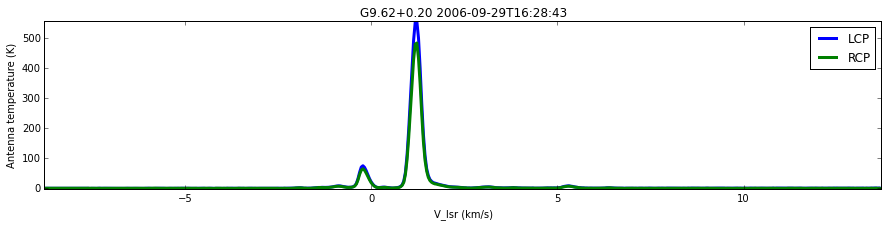

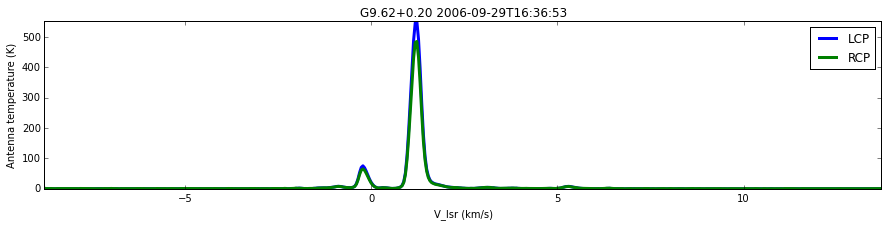

In [17]:
new_spec1, new_spec2 = freq_switch(on_fs1, on_fs2)
plot_spec(new_spec1)
plot_spec(new_spec2)

## Baseline subtraction
The frequency-switching technique removes any channel-based (correlator) artefacts and systematic offsets.  However, since we are changing frequencies to do this, there may still be frequency-dependent effects.  Since the HartRAO 26m telescope has a blocked aperture, standing waves are produced between the main surface and the secondary.  This manifests as a bandpass ripple.  Since our total bandwidth is 1MHz, we don't see much of this ripple - it generally just looks like a slope in the spectral baseline.

If this is not removed, the measured amplitude of your maser spectrum will be incorrect.

Let us zoom into the baseline of one of the spectra above.

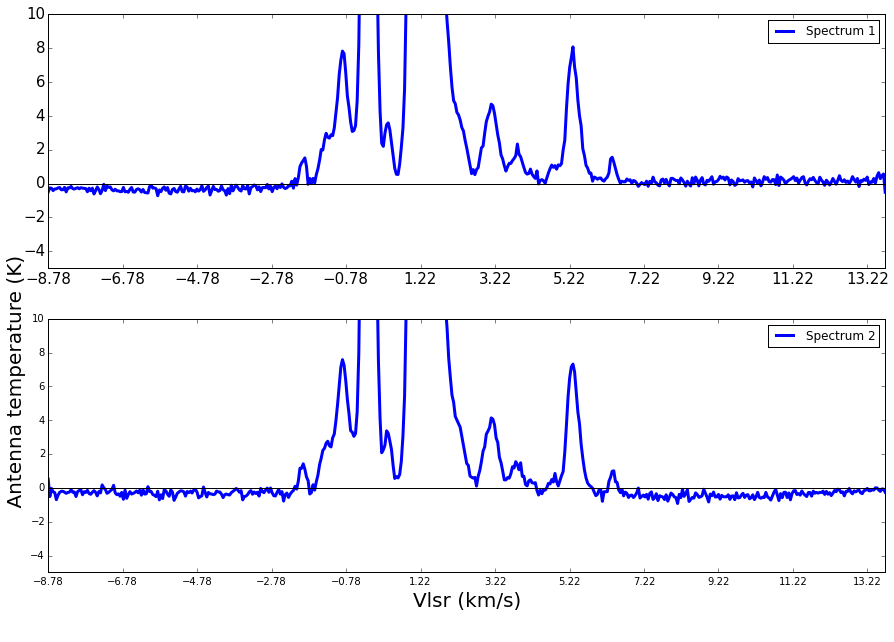

In [18]:
plt.figure(figsize = [15,10])
ax = plt.subplot(211)
ax.plot(new_spec1['Vlsr'], new_spec1['LCP'], linewidth=3, label = 'Spectrum 1')
plt.axis('tight')
plt.ylim(-5, 10)
ax.axhline(0,color='k')
plt.legend()
#plt.xlabel('Vlsr (km/s)', fontsize=20)
#plt.ylabel('Antenna temperature (K)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
start, end = ax.get_xlim()
tick_interval = 2
ticks = ax.xaxis.set_ticks(np.arange(start, end, tick_interval))  # makes it easier to get velocity ranges
ax = plt.subplot(212)
ax.plot(new_spec2['Vlsr'], new_spec2['LCP'], linewidth=3, label = 'Spectrum 2')
plt.axis('tight')
plt.ylim(-5, 10)
ax.axhline(0,color='k')
plt.xlabel('Vlsr (km/s)', fontsize=20)
plt.ylabel('                    Antenna temperature (K)', fontsize=20)
plt.legend()
start, end = ax.get_xlim()
tick_interval = 2
ticks = ax.xaxis.set_ticks(np.arange(start, end, tick_interval))  # makes it easier to get velocity ranges

As you can see, there is a slope in the baseline and it may not be passing through 0. This slope will not be constant - it will depend on the frequency of the observation, and the Doppler-shift of the source due to Earth's motion will cause the on-sky frequency to change every day. 

Numpy has a very useful concept of masked arrays, where certain values can be excluded from operations. We are going to mask the range over which we have line emission.

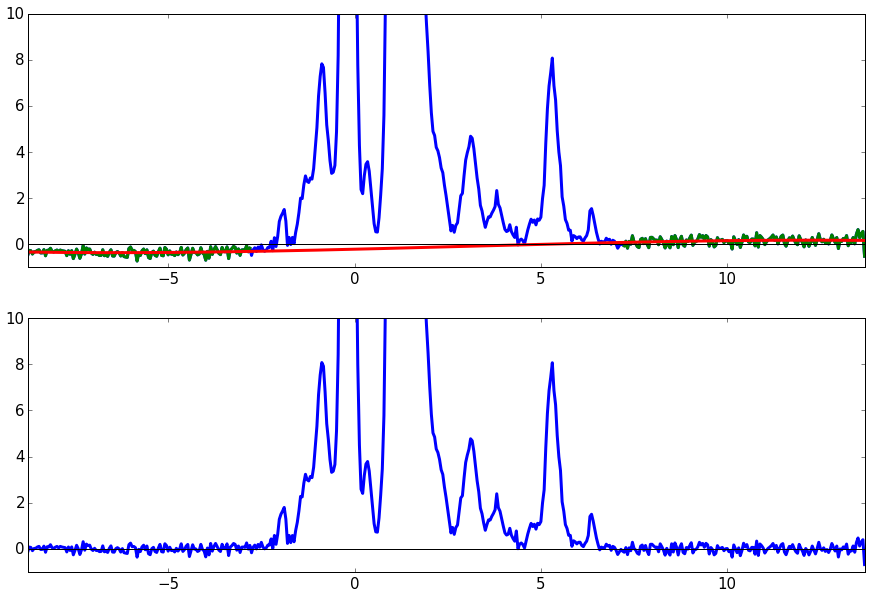

In [19]:
#define a range over which to fit fit the baseline.
#We exclude the channels containing line emission.
line_range = [-2.78, 7.22]
line_chans = np.where(np.logical_and(new_spec1['Vlsr']>=line_range[0], new_spec1['Vlsr']<=line_range[1]))
mask = np.zeros(len(new_spec1['Vlsr']))
mask[line_chans] = 1
vel_mask = np.ma.array(new_spec1['Vlsr'], mask = mask)
amp_mask = np.ma.array(new_spec1['LCP'], mask = mask)

#fit a third-order polynomial to the baseline
p = np.poly1d(np.ma.polyfit(vel_mask, amp_mask,  3))
basefit = p(new_spec1['Vlsr'])

#inspect the fit
plt.figure(figsize = [15,10])
ax = plt.subplot(211)
plt.plot(new_spec1['Vlsr'], new_spec1['LCP'], linewidth=3)
plt.plot(vel_mask, amp_mask, linewidth=3)
plt.plot(new_spec1['Vlsr'], basefit, linewidth=3)
plt.axis('tight')
plt.ylim(-1,10)
ax.axhline(0,color='k')
ax.tick_params(axis='both', which='major', labelsize=15)

#subtract the baseline fit
ax = plt.subplot(212)
plt.plot(new_spec1['Vlsr'], new_spec1['LCP'] - basefit, linewidth=3)
plt.axis('tight')
plt.ylim(-1,10)
plt.ylim(-1,10)
ax.axhline(0,color='k')
ax.tick_params(axis='both', which='major', labelsize=15)

In [20]:
def flatten_baseline(Vlsr, Amp, line_range):
    """
    Remove residual baseline variation after frequency- or position-switching.
    Inputs:
        Vlsr: array of velocity values
        Amp: array of intensity as a function of velocity
        line_range: two-element array with start and end velocity of line emission.
        
    The line emmission range is masked before a fit is performed on the baseline.
    
    Returns: Corrected amplitude
    
    To do:  generalise mask to use multiple line ranges.
    """
    line_chans = np.where(np.logical_and(Vlsr>=line_range[0], Vlsr<=line_range[1]))
    mask = np.zeros(len(Amp))
    mask[line_chans] = 1
    vel_mask = np.ma.array(Vlsr, mask = mask)
    amp_mask = np.ma.array(Amp, mask = mask)

    #In general, we have found that a third-order polynomial is sufficient to fit the spectral baseline
    p = np.poly1d(np.ma.polyfit(vel_mask, amp_mask,  3))
    basefit = p(Vlsr)

    plt.figure(figsize = [15,5])
    plt.plot(Vlsr, Amp)
    plt.plot(vel_mask, amp_mask)
    plt.plot(Vlsr, basefit)
    lim = plt.axis('tight')
    plt.ylim(-2,5)
    plt.ylabel('Amplitude')
    plt.xlabel('Vlsr')

    Amp = Amp - basefit
    
    return Amp

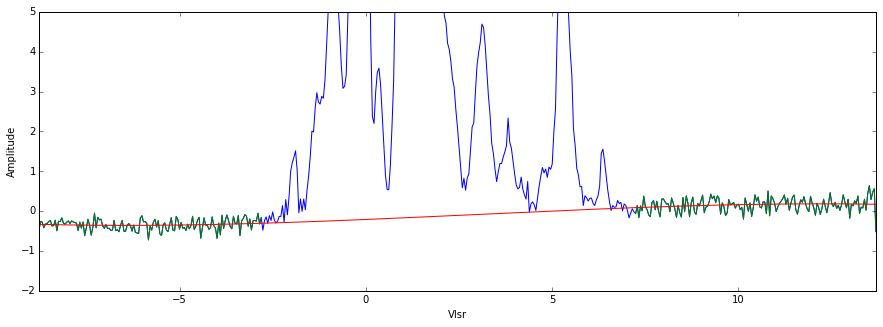

In [21]:
new_spec1['LCP'] = flatten_baseline(new_spec1['Vlsr'], new_spec1['LCP'], line_range)

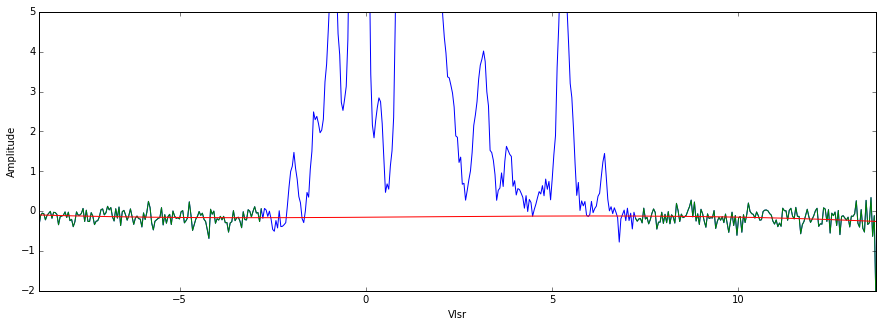

In [22]:
#repeat for RCP
new_spec1['RCP'] = flatten_baseline(new_spec1['Vlsr'], new_spec1['RCP'], line_range)

Do the same for the second observation

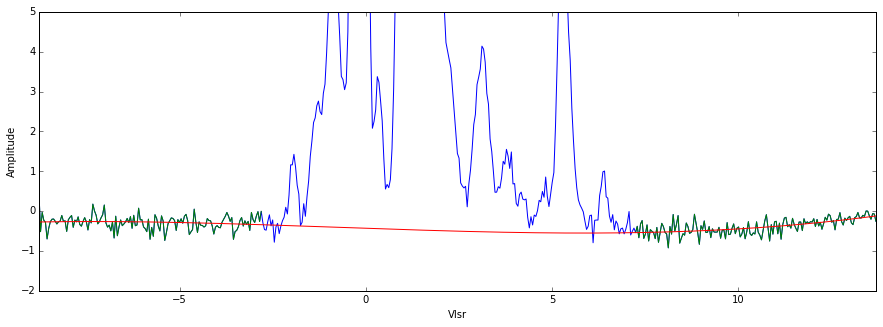

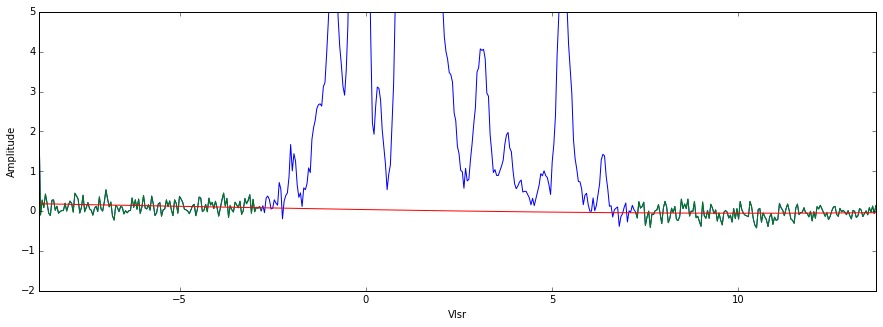

In [23]:
new_spec2['LCP'] = flatten_baseline(new_spec2['Vlsr'], new_spec2['LCP'], line_range)
new_spec2['RCP'] = flatten_baseline(new_spec2['Vlsr'], new_spec2['RCP'], line_range)

After this we can average the two observations (new_spec1, and new_spec2) together - but we do not want to combine the two polarisations until we have done a gain correction, which is polarisation-dependent. 

Note that we need to modify the time of the observation to reflect the midpoint between the two observations.  There are many manipulations that can be done with time objects - see http://astropy.readthedocs.org/en/latest/time/ for information on different time formats and how to work with them.

In [24]:
def ave_spec(spec1, spec2):
    """
    Average two spectra in time.
    Return a new spectrum.
    """
    #find mean of the corrected spectra
    mean_lcp = np.mean(np.vstack([spec1['LCP'], spec2['LCP']]), axis=0)
    mean_rcp = np.mean(np.vstack([spec1['RCP'], spec2['RCP']]), axis=0)
    
    #find mid point between times of observation
    time1 = Time(spec1['date'], scale='utc', format='isot')
    time2 = Time(spec2['date'], scale='utc', format='isot')
    dt = (time2 - time1)/2
    mid_time = time1 +dt
    
    #construct new spectrum
    mean_spec = {'object' : spec1['object'],
                 'longitude' : spec1['longitude'],
                 'latitude' : spec1['latitude'],
                 'equinox' : spec1['equinox'],
                 'HPBW' : spec1['HPBW'],
                 'date' : mid_time.iso,    
                 'Vlsr' : spec1['Vlsr'],
                 'LCP' : mean_lcp,
                 'RCP' : mean_rcp,
                 'Tsys_lcp' : np.mean([spec1['Tsys_lcp'], spec2['Tsys_lcp']]),
                 'DTsys_lcp' : np.mean([spec1['DTsys_lcp'], spec2['DTsys_lcp']]) ,
                 'Tsys_rcp' : np.mean([spec1['Tsys_rcp'], spec2['Tsys_rcp']]),
                 'DTsys_rcp': np.mean([spec1['DTsys_rcp'], spec2['DTsys_rcp']])}
    return mean_spec
    

In [25]:
time_averaged_spec = ave_spec(new_spec1, new_spec2)

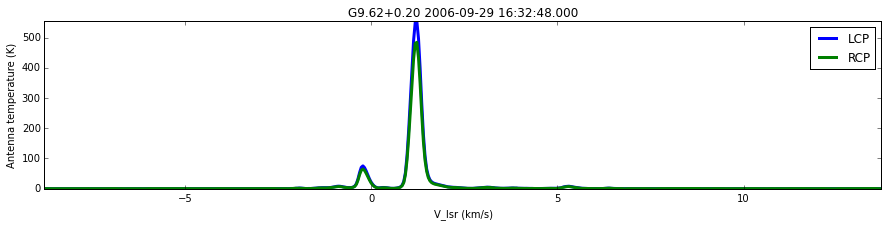

In [26]:
plot_spec(time_averaged_spec)